In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [138]:
data = pd.read_excel('AirQualityUCI.xlsx')
data.replace(-200, np.nan, inplace=True)
data.dropna(subset=['C6H6(GT)'] ,axis=0, inplace=True)

In [139]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [140]:
# %pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport

In [141]:
report = ProfileReport(data, title='AirQuality', explorative=True)

In [142]:
# report.to_notebook_iframe()

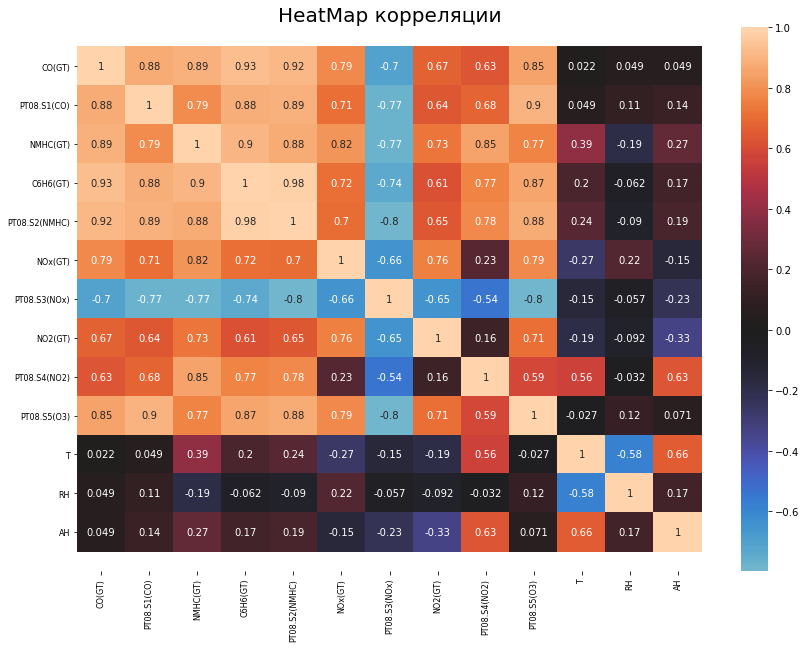

In [143]:
plt.figure(figsize=(14,10))
ax = sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)
plt.title('HeatMap корреляции', fontsize=20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Выводы по EDA

Параметр NMHC(GT) имеет более 90% пропусков, при заполнении пропусков будет удален <br>
Некоторые параметры имеют высокую взаимную корреляцию

<AxesSubplot:xlabel='C6H6(GT)'>

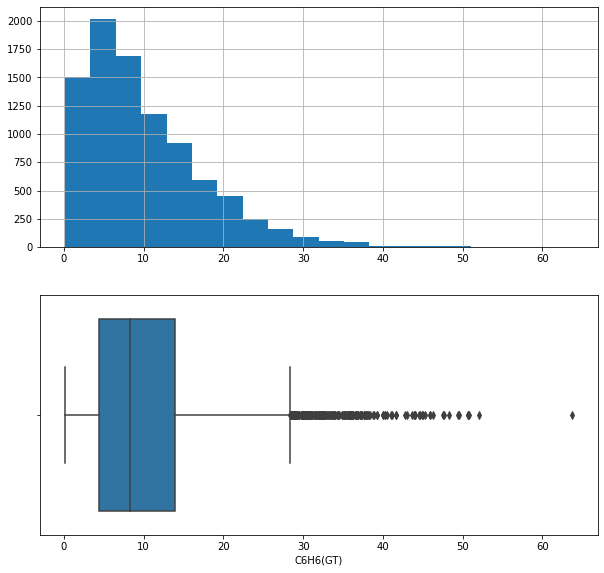

In [144]:
# Вывод target колонки
plt.figure(figsize = (10, 15))
plt.subplot(3, 1, 1)
data['C6H6(GT)'].hist(bins=20)
plt.subplot(3, 1, 2)
sns.boxplot(data['C6H6(GT)'])


Данные имеют большое количество выбросов, при обучении модели будет использоваться MAE, как основная метрика, так как она более устойчива к ним. 

In [145]:
cols_with_missing = [col for col in data.columns if data[col].isnull().any()]

In [146]:
# Колонки в которых встречаются пропущенные значения
data[cols_with_missing].describe()

,CO(GT),NMHC(GT),NOx(GT),NO2(GT)
count,7344.000000,887.000000,7396.000000,7393.000000
mean,2.129711,218.607666,242.174351,112.129974
std,1.436472,206.615130,206.304577,47.618852
min,0.100000,7.000000,2.000000,2.000000
25%,1.100000,66.000000,97.000000,77.000000
50%,1.800000,145.000000,178.000000,108.500000
75%,2.800000,297.000000,321.000000,140.000000
max,11.900000,1189.000000,1479.000000,332.600000


In [147]:
for col in cols_with_missing:
    print(col, len(data[data[col].isnull()]))

CO(GT) 1647
NMHC(GT) 8104
NOx(GT) 1595
NO2(GT) 1598


NMHC(GT) - отсутсвует более 90% записей, в отдельных случаях имеет смысл предсказать значение этой переменной с помощью линейной модели, в данном случае есть два варианта, либо удалить столбец полностью, либо добавить отдельный бинарный параметр, отвечающий за наличие данных по NMHC(GT) в n-ой строке датафрема. Остальные столбцы можно заполнить средним, в соответсвии с распредлением. В целом, эти данные представляют собой временной ряд, и имеет смысл воспользоваться алгоритмом заполнения пропусков в них.

### Заполнение пропусков

Для заполнения 

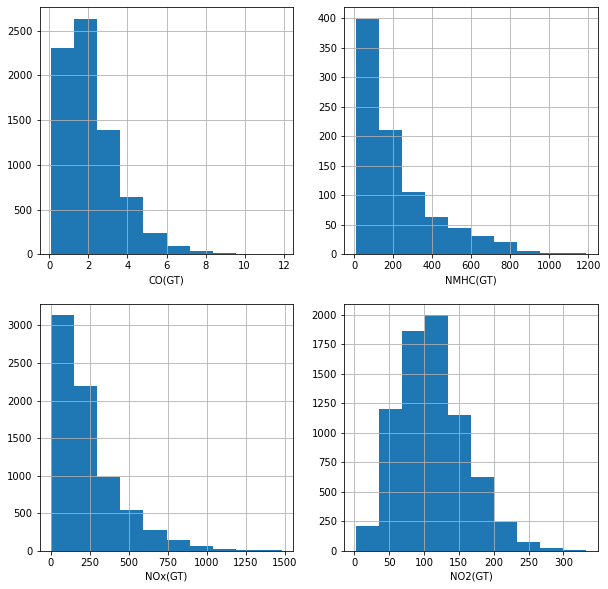

In [148]:
plt.figure(figsize=(10,10))
i = 1
for col in cols_with_missing:
    plt.subplot(2, 2, i)
    plt.xlabel(col)
    data[col].hist()
    i += 1

Для 3 остальных параметров лучше использовать median, как способ заполнения, так как mean будет чувтвителен к выбросам, которые присутвуют в 2/3 параметров. Для NO2, можно использовать mean, так как выбросов не так много.

In [149]:
data.drop('NMHC(GT)', axis = 1, inplace=True)
data.set_index(['Date', 'Time'], inplace=True)
y = data['C6H6(GT)'] 
data.drop('C6H6(GT)', axis=1, inplace=True)

Изначально, я использовал Imputer со стратегией mean, ради эксперимента решил попробовать заполнять через метод ближайших соседей.

In [150]:
from sklearn.impute import KNNImputer
imp = KNNImputer()
c = data.columns
data = pd.DataFrame(imp.fit_transform(data))
data.columns = c

In [151]:
cols_with_missing = [col for col in data.columns if data[col].isnull().any()]
cols_with_missing

[]

## Нормализация данных (z-score)

In [152]:
from sklearn.preprocessing import StandardScaler as scaler
sc = scaler()
c = data.columns
data = pd.DataFrame(sc.fit_transform(data, y))
data.columns = c

In [154]:
data.head()

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.380014,1.199102,0.399045,-0.317784,0.860118,0.116775,0.681301,0.614165,-0.533950,-0.020638,-0.663157
1,-0.043779,0.886995,0.058920,-0.634133,1.317671,-0.333185,0.296392,-0.126815,-0.567915,-0.088497,-0.743065
2,0.097485,1.392586,0.000828,-0.493534,1.186246,0.138201,0.284115,0.128543,-0.726423,0.273897,-0.681767
3,0.097485,1.270507,0.034559,-0.287655,0.999331,0.309614,0.368608,0.452918,-0.828320,0.621852,-0.591440
4,-0.326308,0.794860,-0.388020,-0.493534,1.439361,0.181055,0.097799,0.218892,-0.811337,0.597308,-0.586284


## Линейная регрессия

Алгоритм ниже - линейная регрессия с минимизацией MSE, что не очень хорошо подходит к данному датафрейму.
Написал так, потому что mae не может быть дифференцирована, градиентный спуск написан, через производные для MSE

## Линейная регрессия без регуляризации

In [155]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

def lin_reg(data, target, error = mae, eps=0.05, k = 3):
    data['b'] = 1
    data = data.to_numpy()
    target = target.to_numpy()
    weights = np.zeros(data.shape[1])
    er = 0
    new_target = np.dot(data, weights)
    new_er = error(new_target, target)
    t = 1
    while abs(new_er - er) > eps:
        grad = np.zeros(data.shape[1])
        for i in range(len(data)):
            dif = sum(data[i] * weights) - target[i]
            for j in range(data.shape[1]):
                grad[j] += dif * data[i][j] * 2 / data.shape[0]
                
        for j in range(len(weights)):
            weights[j] -= k / t  * grad[j]
        new_target = np.dot(data, weights)
        er = new_er
        new_er = error(new_target, target)
        t += 1
    return weights



def mape(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [194]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data, y, shuffle=False)

In [190]:
data.shape

(8991, 11)

In [191]:
from sklearn.metrics import mean_absolute_error as mae
#from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
w = lin_reg(x_train, y_train)
tmp = x_valid
tmp['b'] = 1
print('Линейная регрессия (ручная функция) mae', mae(np.dot(tmp, w), y_valid))
print('Линейная регрессия (ручная функция) mape', mape(np.dot(tmp, w), y_valid))
pd.DataFrame(w, tmp.columns)

Линейная регрессия (ручная функция) mae 1.7511925576045555
Линейная регрессия (ручная функция) mape 75.3689486532315


,0
CO(GT),1.880877
PT08.S1(CO),-0.636205
PT08.S2(NMHC),4.514028
NOx(GT),1.275329
PT08.S3(NOx),0.617981
NO2(GT),-0.769982
PT08.S4(NO2),1.868043
PT08.S5(O3),0.639640
T,0.095772
RH,-0.263680


In [198]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data, y, shuffle=False)
model = LinearRegression()
model.fit(x_train, y_train)
print(x_train.shape)
print('Лин. рег, sklearn, mae', mae(model.predict(x_valid), y_valid))
print('Линейная регрессия sklearn, mape', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

(6743, 11)
Лин. рег, sklearn, mae 1.8588962258235768
Линейная регрессия sklearn, mape 75.68491334903754


,Коэф
CO(GT),1.489999
PT08.S1(CO),-0.628138
PT08.S2(NMHC),6.750028
NOx(GT),0.764830
PT08.S3(NOx),1.089169
NO2(GT),-0.846181
PT08.S4(NO2),0.720075
PT08.S5(O3),0.411138
T,-0.196291
RH,-0.250397


Алгоритм из библиотеки точнее на 1/100, скорее всего, потому что использует не градиентный спуск, как метод оптимизации, а аналитическое решение регрессии.

In [165]:
data.head()

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.380014,1.199102,0.399045,-0.317784,0.860118,0.116775,0.681301,0.614165,-0.533950,-0.020638,-0.663157
1,-0.043779,0.886995,0.058920,-0.634133,1.317671,-0.333185,0.296392,-0.126815,-0.567915,-0.088497,-0.743065
2,0.097485,1.392586,0.000828,-0.493534,1.186246,0.138201,0.284115,0.128543,-0.726423,0.273897,-0.681767
3,0.097485,1.270507,0.034559,-0.287655,0.999331,0.309614,0.368608,0.452918,-0.828320,0.621852,-0.591440
4,-0.326308,0.794860,-0.388020,-0.493534,1.439361,0.181055,0.097799,0.218892,-0.811337,0.597308,-0.586284


## Проверка гипотез

Для улучшения базовой модели можно удалить коррелирующие строки, проверка через критерий Фишера. Для след. переменных (CO, PT08.S1), (CO, PT08.S2)<br>
H0 - коэфициент корреляции не равен 1 <br>
H1 - коэфициент корреляции равен 1

In [166]:
# Критерий Фишера
def f1(x, y, a):
    x_m = np.mean(x)
    y_m = np.mean(y)
    r = sum((x-x_m)*(y-y_m))
    r /= sum((x-x_m) ** 2) ** 0.5
    r /= sum((y-y_m) ** 2) ** 0.5
    t = r/(1-r**2)**0.5 * (len(x)-2)**0.5
    t1 = stats.t.ppf(1 - a, len(x)-2)
    if abs(t) > t1:
        return 'Отвергаем H0'
    else:
        return 'Не отвергаем H0'

In [167]:
print(f1(data['CO(GT)'], data['PT08.S1(CO)'], 0.95))
print(f1(data['CO(GT)'], data['PT08.S2(NMHC)'], 0.95))

Отвергаем H0
Отвергаем H0


Оба параметра имеют высокий коэфициент корреляции и вносят помехи в данные. Стоит их удалить

In [199]:
new_data = data.drop(['PT08.S1(CO)','PT08.S2(NMHC)'], axis = 1)

## Результаты модели после удаления коллинеарных параметров

In [200]:
x_train, x_valid, y_train, y_valid = train_test_split(new_data, y, shuffle=False)
model = LinearRegression()
print(x_train.shape)
model.fit(x_train, y_train)
print('Лин. рег, sklearn, mae', mae(model.predict(x_valid), y_valid))
print('Линейная регрессия sklearn, mape', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

(6743, 9)
Лин. рег, sklearn, mae 1.5495232323166976
Линейная регрессия sklearn, mape 64.82653796049141


,Коэф
CO(GT),2.606220
NOx(GT),2.133906
PT08.S3(NOx),-0.206922
NO2(GT),-0.493852
PT08.S4(NO2),3.630688
PT08.S5(O3),1.010691
T,0.237853
RH,-0.687573
AH,-0.905107


При удалении первого параметра ошибки незначительно понижаются, а при удалении второго повышаются. Разница не настолько велика, чтобы делать выводы о влиянии параметра на результат работы модели.

Подбор гиперпараметров для модели с градиентным спуском (Шаг и точность)

In [207]:
x_train, x_valid, y_train, y_valid = train_test_split(new_data, y, shuffle = False)
from sklearn.metrics import mean_absolute_error as mae
#from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
for i in range(1, 5):
    w = lin_reg(x_train, y_train, eps=0.01, k = i)
    tmp = x_valid
    tmp['b'] = 1
    print('k = ', str(i), ', mae', mae(np.dot(tmp, w), y_valid))
    print('mape', mape(np.dot(tmp, w), y_valid))


k =  1 , mae 1.6070574420179413
mape 63.68380462697143
k =  2 , mae 1.556476887581509
mape 63.41438772545972
k =  3 , mae 1.5509001363370698
mape 63.748260238799816
k =  4 , mae 1.552974345298104
mape 64.33832508538543


При шаге равном 5/t, где t - номер шага регрессия перестает сходится при заданой точности. Оптимальный выбор k = 1

In [205]:
for i in range(1, 6):
    w = lin_reg(x_train, y_train, eps=0.002 * i, k = 1)
    tmp = x_valid
    tmp['b'] = 1
    print('eps = ', str(i * 0.002), ', mae', mae(np.dot(tmp, w), y_valid))
    print('mape', mape(np.dot(tmp, w), y_valid))


eps =  0.002 , mae 1.6111656824944594
mape 64.07186686357727
eps =  0.004 , mae 1.6070574420179413
mape 63.68380462697143
eps =  0.006 , mae 1.6070574420179413
mape 63.68380462697143
eps =  0.008 , mae 1.6070574420179413
mape 63.68380462697143
eps =  0.01 , mae 1.6070574420179413
mape 63.68380462697143


Оптимальная точность получается при eps >= 0.01

## Nonlinear feature engineering

Возьмем самый важный фактор (с максимальным по мoдулю весом), и возведем его в квадрат и добавим его как доп. столбец

In [209]:
new_data['PT08.S4^2'] = new_data['PT08.S4(NO2)'] ** 2

In [210]:
x_train, x_valid, y_train, y_valid = train_test_split(new_data, y, shuffle=False)
model = LinearRegression()
print(x_train.shape)
model.fit(x_train, y_train)
print('Лин. рег, sklearn, mae', mae(model.predict(x_valid), y_valid))
print('Линейная регрессия sklearn, mape', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

(6743, 10)
Лин. рег, sklearn, mae 0.9872537641218808
Линейная регрессия sklearn, mape 24.436426952714342


,Коэф
CO(GT),1.673884
NOx(GT),2.305694
PT08.S3(NOx),-0.525129
NO2(GT),-0.198781
PT08.S4(NO2),3.288504
PT08.S5(O3),0.940006
T,1.018792
RH,-0.099191
AH,-1.371663
new_column,0.718283


In [214]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(loss='huber', shuffle=False)
model.fit(x_train, y_train)
print('SGD MAE без выбора гиперпараметров', mae(model.predict(x_valid), y_valid))
print('SGD MAPE без выбора гиперпараметров ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

SGD MAE без выбора гиперпараметров 1.5262938337648344
SGD MAPE без выбора гиперпараметров  38.010516778287


,Коэф
CO(GT),1.844440
NOx(GT),1.412085
PT08.S3(NOx),-0.601193
NO2(GT),0.327024
PT08.S4(NO2),2.398761
PT08.S5(O3),1.204616
T,0.861256
RH,-0.088101
AH,-0.761936
new_column,1.103120


## Выбор гиперпараметров для SGD

Изначально в функции sklearn, SGD используется с регуляризацией L2

In [217]:
for i in range(500, 2500, 250):
    model = SGDRegressor(loss='huber', shuffle=False, max_iter=i)
    model.fit(x_train, y_train)
    print('max_iter = ', i )
    print('SGD MAE', mae(model.predict(x_valid), y_valid))
    print('SGD MAPE ', mape(model.predict(x_valid), y_valid))

max_iter =  500
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  750
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  1000
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  1250
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  1500
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  1750
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  2000
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287
max_iter =  2250
SGD MAE 1.5262938337648344
SGD MAPE  38.010516778287


In [220]:
model = SGDRegressor(loss='huber', shuffle=False, penalty='l1')
model.fit(x_train, y_train)
print('Регуляризация l1')
print('SGD MAE', mae(model.predict(x_valid), y_valid))
print('SGD MAPE ', mape(model.predict(x_valid), y_valid))

Регуляризация l1
SGD MAE 1.5194100226985903
SGD MAPE  37.82607948805254


In [221]:
model = SGDRegressor(loss='huber', shuffle=False, penalty='elasticnet')
model.fit(x_train, y_train)
print('Регуляризация elastic net')
print('SGD MAE', mae(model.predict(x_valid), y_valid))
print('SGD MAPE ', mape(model.predict(x_valid), y_valid))

Регуляризация elastic net
SGD MAE 1.5252888369563549
SGD MAPE  37.98409297978299


При выборе количества проходов по данным, ошибка не меняется. Лучшие результаты модель показывает при регуляризации L1

## Линейная регрессия с регуляризацией

In [222]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [232]:
model = Ridge()
model.fit(x_train, y_train)
print('Регуляризация L2')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация L2
Ridge MAE 0.9884763100298255
Ridge MAPE  24.437483704907688


,Коэф
CO(GT),1.676460
NOx(GT),2.302619
PT08.S3(NOx),-0.525074
NO2(GT),-0.197089
PT08.S4(NO2),3.284671
PT08.S5(O3),0.940851
T,1.015206
RH,-0.101664
AH,-1.367250
new_column,0.718358


In [233]:
model = Lasso()
model.fit(x_train, y_train)
print('Регуляризация L1')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация L1
Ridge MAE 2.2693721423826685
Ridge MAPE  71.98022163901186


,Коэф
CO(GT),4.248524
NOx(GT),0.000000
PT08.S3(NOx),-0.333150
NO2(GT),0.000000
PT08.S4(NO2),0.895557
PT08.S5(O3),0.786863
T,0.000000
RH,-0.000000
AH,0.000000
new_column,0.488296


In [234]:
model = ElasticNet()
model.fit(x_train, y_train)
print('Регуляризация Elastic net')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация Elastic net
Ridge MAE 3.3213268576844563
Ridge MAPE  105.84691129785597


,Коэф
CO(GT),1.601693
NOx(GT),0.859276
PT08.S3(NOx),-0.817019
NO2(GT),0.713230
PT08.S4(NO2),1.213820
PT08.S5(O3),1.086189
T,0.017348
RH,-0.100877
AH,-0.000000
new_column,0.968830


Параметр CO(GT) имеет большой вес во всех трех моделях. Возможно имеет смысл добавить квадрат и этого параметра

In [237]:
new_data['CO^2'] = new_data['CO(GT)']**2
x_train, x_valid, y_train, y_valid = train_test_split(new_data, y, shuffle=False)

In [252]:
model = Ridge()
model.fit(x_train, y_train)
print('Регуляризация L2')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация L2
Ridge MAE 0.9832387670395071
Ridge MAPE  23.52606739773212


,Коэф
CO(GT),1.825105
NOx(GT),2.358777
PT08.S3(NOx),-0.467723
NO2(GT),-0.263463
PT08.S4(NO2),3.260591
PT08.S5(O3),0.923619
T,1.050303
RH,-0.084565
AH,-1.363063
new_column,0.747662


In [239]:
model = Lasso()
model.fit(x_train, y_train)
print('Регуляризация L1')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация L1
Ridge MAE 2.2471311878644635
Ridge MAPE  71.07614487772595


,Коэф
CO(GT),4.158385
NOx(GT),0.000000
PT08.S3(NOx),-0.360516
NO2(GT),0.000000
PT08.S4(NO2),0.903625
PT08.S5(O3),0.806890
T,0.000000
RH,-0.000000
AH,0.000000
new_column,0.468799


In [240]:
model = ElasticNet()
model.fit(x_train, y_train)
print('Регуляризация Elastic net')
print('Ridge MAE', mae(model.predict(x_valid), y_valid))
print('Ridge MAPE ', mape(model.predict(x_valid), y_valid))
t = list(x_train.columns)
coef = pd.DataFrame(model.coef_, t)
coef.columns = ['Коэф']
coef

Регуляризация Elastic net
Ridge MAE 3.1159513051961776
Ridge MAPE  99.68769412946888


,Коэф
CO(GT),1.399025
NOx(GT),0.675264
PT08.S3(NOx),-0.900286
NO2(GT),0.753929
PT08.S4(NO2),1.178334
PT08.S5(O3),1.071893
T,0.017954
RH,-0.144614
AH,-0.000000
new_column,0.770380


## Настройка гиперпараметров для регуляризации

L2 имеет результат лучше чем, два других метода, следовательно стоит повысить коэф. регуляризации при L1

In [246]:
print('Регуляризация L1')

for i in range(1, 5):
    model = Lasso(alpha=i)
    model.fit(x_train, y_train)
    print('alpha = ', i)
    print('Lasso MAE', mae(model.predict(x_valid), y_valid))
    print('Lasso MAPE ', mape(model.predict(x_valid), y_valid))

Регуляризация L1
alpha =  1
Ridge MAE 2.2471311878644635
Ridge MAPE  71.07614487772595
alpha =  2
Ridge MAE 3.3142341095505214
Ridge MAPE  125.58295545670097
alpha =  3
Ridge MAE 3.6492285218242237
Ridge MAPE  145.57749357805056
alpha =  4
Ridge MAE 4.053349362216945
Ridge MAPE  162.56218655559337


И Ridge, и Lasso показывают наилучшие результаты при alpha = 1 -> В Elastic net используем alpha = 1

In [251]:
for i in np.arange(0, 1.1, 0.1):
    model = ElasticNet(l1_ratio=i)
    model.fit(x_train, y_train)
    print('L1 ratio = ', i)
    print('EN MAE', mae(model.predict(x_valid), y_valid))
    print('EN MAPE ', mape(model.predict(x_valid), y_valid))

L1 ratio =  0.0
EN MAE 3.098192190065523
EN MAPE  99.17404097014827
L1 ratio =  0.1
EN MAE 3.0941315130620177
EN MAPE  98.97648892006603
L1 ratio =  0.2
EN MAE 3.104417049880433
EN MAPE  99.34287177924035
L1 ratio =  0.30000000000000004
EN MAE 3.1126071025835134
EN MAPE  99.62759952169053
L1 ratio =  0.4
EN MAE 3.117426498434468
EN MAPE  99.77456654918763
L1 ratio =  0.5
EN MAE 3.1159513051961776
EN MAPE  99.68769412946888
L1 ratio =  0.6000000000000001
EN MAE 3.06724121978516
EN MAPE  97.75234007136838
L1 ratio =  0.7000000000000001
EN MAE 2.986823155694638
EN MAPE  94.63521990032486
L1 ratio =  0.8
EN MAE 2.828163721296577
EN MAPE  89.21522451886852
L1 ratio =  0.9
EN MAE 2.5748935551084977
EN MAPE  81.1115982502608
L1 ratio =  1.0
EN MAE 2.2471311878644635
EN MAPE  71.07614487772595


# Выводы

В данном случае, наилучший результат имеет регуляризация L2